In [1]:
# Data collection

In [11]:
import requests
import time
import datetime
import pandas as pd

API_KEYS = ["rl_pNMrjMQxT6YzThw14C2FVFbtu", "rl_tCz2ftGtDvC3qokxwb8TRo5pu"]  
# rotate keys to increase quota
key_idx = 0
SITE = "stackoverflow"
TAG = "nlp"
PAGESIZE = 100    
MAX_RECORDS = 20000  

all_questions = []
page = 1

# ——— 1. Fetch questions until 20,000 or run out (Stack Exchange API, n.d.)
while len(all_questions) < MAX_RECORDS:
    print(f"Fetching page {page} (total collected so far: {len(all_questions)})")
    params = {
        "page": page,
        "pagesize": PAGESIZE,
        "order": "desc",
        "sort": "creation",
        "tagged": TAG,
        "site": SITE,
        "filter": "withbody",
        "key": API_KEYS[key_idx]
    }
    resp = requests.get("https://api.stackexchange.com/2.3/questions", params=params)
    data = resp.json()

    # handle rate-limit or other errors （ChatGPT1）
    if data.get("error_id") or data.get("quota_remaining", 1) == 0:
        print(f"Quota exhausted for key {API_KEYS[key_idx]}")
        # try next key if available
        if key_idx + 1 < len(API_KEYS):
            key_idx += 1
            print(f"Switching to next key: {API_KEYS[key_idx]}")
            continue
        # otherwise wait until next UTC midnight
        now = datetime.datetime.utcnow()
        next_reset = (now + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        wait_seconds = (next_reset - now).total_seconds() + 60
        print(f"No keys left; sleeping {wait_seconds/3600:.2f}h until quota reset")
        time.sleep(wait_seconds)
        continue

    items = data.get("items", [])
    if not items:
        print("No more items returned; ending fetch.")
        break

    # record each question (even if no body or no accepted answer) (Verma, 2023)
    for q in items:
        all_questions.append({
            "question_id": q["question_id"],
            "title": q.get("title", ""),
            "body": q.get("body", ""),               
            "tags": ",".join(q.get("tags", [])),     
            "creation_date": pd.to_datetime(q["creation_date"], unit="s"),
            "view_count": q.get("view_count", 0),
            "accepted_answer_id": q.get("accepted_answer_id")      
        })

    page += 1
    time.sleep(0.2)

print(f"Done fetching questions: pages={page-1}, total questions={len(all_questions)}")

# ——— 2. Fetch accepted answers in batches of 100 ———
answer_ids = [q["accepted_answer_id"] for q in all_questions if q.get("accepted_answer_id")]
answers = {}
for i in range(0, len(answer_ids), 100):
    batch = answer_ids[i:i+100]
    ids_str = ";".join(map(str, batch))
    params = {
        "site": SITE,
        "filter": "withbody",
        "key": API_KEYS[key_idx]
    }
    resp = requests.get(f"https://api.stackexchange.com/2.3/answers/{ids_str}", params=params)
    data = resp.json()
    if "backoff" in data:   # （ChatGPT1）
        time.sleep(data["backoff"])
    for a in data.get("items", []):
        answers[a["answer_id"]] = {
            "body": a.get("body", ""),
            "owner_reputation": a.get("owner", {}).get("reputation", 0)
        }
    time.sleep(0.2)

# ——— 3. Merge answers back into questions ———
for q in all_questions:
    aid = q.get("accepted_answer_id")
    if aid and aid in answers:
        q["accepted_answer_body"] = answers[aid]["body"]
        q["answerer_reputation"] = answers[aid]["owner_reputation"]
    else:
        q["accepted_answer_body"] = ""
        q["answerer_reputation"] = None

# ——— 4. Save to CSV ———
df = pd.DataFrame(all_questions)
df.to_csv("so_nlp_posts.csv", index=False, encoding="utf-8-sig")
print("Saved dataset to so_nlp_posts.csv")


Fetching page 1 (total collected so far: 0)
Fetching page 2 (total collected so far: 100)
Fetching page 3 (total collected so far: 200)
Fetching page 4 (total collected so far: 300)
Fetching page 5 (total collected so far: 400)
Fetching page 6 (total collected so far: 500)
Fetching page 7 (total collected so far: 600)
Fetching page 8 (total collected so far: 700)
Fetching page 9 (total collected so far: 800)
Fetching page 10 (total collected so far: 900)
Fetching page 11 (total collected so far: 1000)
Fetching page 12 (total collected so far: 1100)
Fetching page 13 (total collected so far: 1200)
Fetching page 14 (total collected so far: 1300)
Fetching page 15 (total collected so far: 1400)
Fetching page 16 (total collected so far: 1500)
Fetching page 17 (total collected so far: 1600)
Fetching page 18 (total collected so far: 1700)
Fetching page 19 (total collected so far: 1800)
Fetching page 20 (total collected so far: 1900)
Fetching page 21 (total collected so far: 2000)
Fetching page

Fetching page 170 (total collected so far: 16891)
Fetching page 171 (total collected so far: 16991)
Fetching page 172 (total collected so far: 17091)
Fetching page 173 (total collected so far: 17190)
Fetching page 174 (total collected so far: 17290)
Fetching page 175 (total collected so far: 17390)
Fetching page 176 (total collected so far: 17490)
Fetching page 177 (total collected so far: 17590)
Fetching page 178 (total collected so far: 17690)
Fetching page 179 (total collected so far: 17790)
Fetching page 180 (total collected so far: 17890)
Fetching page 181 (total collected so far: 17988)
Fetching page 182 (total collected so far: 18085)
Fetching page 183 (total collected so far: 18185)
Fetching page 184 (total collected so far: 18285)
Fetching page 185 (total collected so far: 18385)
Fetching page 186 (total collected so far: 18484)
Fetching page 187 (total collected so far: 18584)
Fetching page 188 (total collected so far: 18684)
Fetching page 189 (total collected so far: 18782)


In [18]:
# ——— 5. Data Collection Visualiztion ———
df = pd.read_csv('so_nlp_posts.csv', parse_dates=['creation_date'], encoding='utf-8-sig')
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20078 entries, 0 to 20077
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   question_id           20078 non-null  int64         
 1   title                 20078 non-null  object        
 2   body                  20078 non-null  object        
 3   tags                  20077 non-null  object        
 4   creation_date         20077 non-null  datetime64[ns]
 5   view_count            20077 non-null  float64       
 6   accepted_answer_id    8193 non-null   float64       
 7   accepted_answer_body  2473 non-null   object        
 8   answerer_reputation   2473 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.4+ MB


/var/folders/9v/gsw0g5bx4d5_67ncd98w25yh0000gn/T/ipykernel_67813/1315824972.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('so_nlp_posts.csv', parse_dates=['creation_date'], encoding='utf-8-sig')


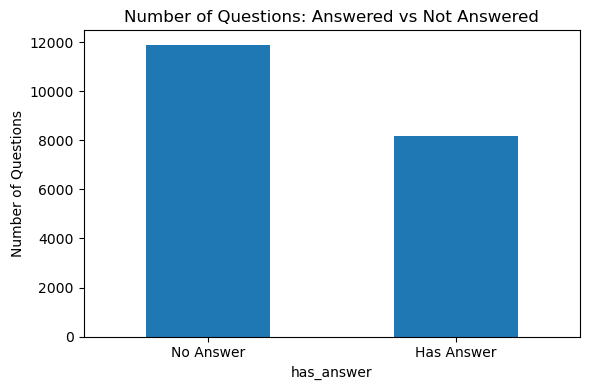

In [19]:
df['has_answer'] = ~df['accepted_answer_id'].isna()
answer_counts = df['has_answer'].value_counts()
avg_views = df.groupby('has_answer')['view_count'].mean()

# Posts with No Answered vs Answered
plt.figure(figsize=(6, 4))
answer_counts.plot(kind='bar')
plt.xticks([0, 1], ['No Answer', 'Has Answer'], rotation=0)
plt.title('Number of Questions: Answered vs Not Answered')
plt.ylabel('Number of Questions')
plt.tight_layout()
plt.show()

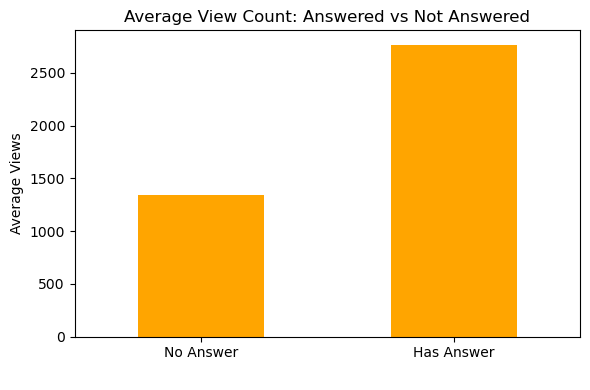

In [10]:
# Average View Count
plt.figure(figsize=(6, 4))
avg_views.plot(kind='bar', color='orange')
plt.xticks([0, 1], ['No Answer', 'Has Answer'], rotation=0)
plt.title('Average View Count: Answered vs Not Answered')
plt.ylabel('Average Views')
plt.xlabel(' ')
plt.tight_layout()
plt.show()

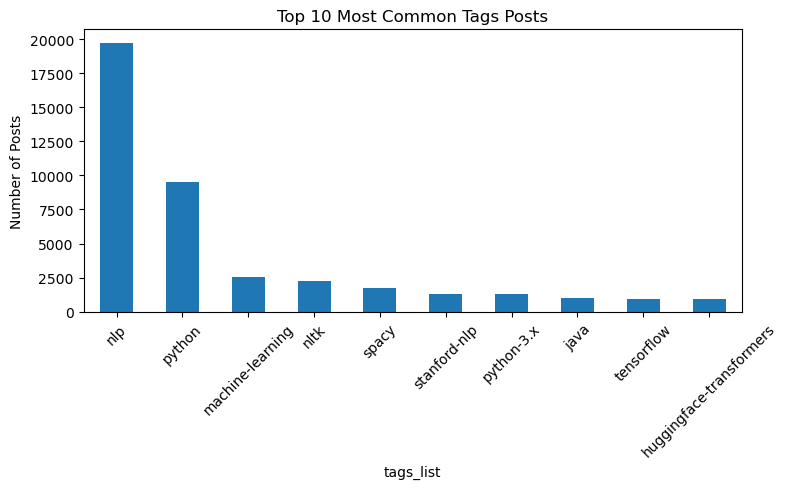

In [11]:
# Split tags and explode into separate rows
df['tags_list'] = df['tags'].str.split(',')
df_exploded = df.explode('tags_list')

# Count top 10 most frequent tags
top_tags = df_exploded['tags_list'].value_counts().head(10)

# Plot top 10 tags
plt.figure(figsize=(8, 5))
top_tags.plot(kind='bar')
plt.title('Top 10 Most Common Tags Posts')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


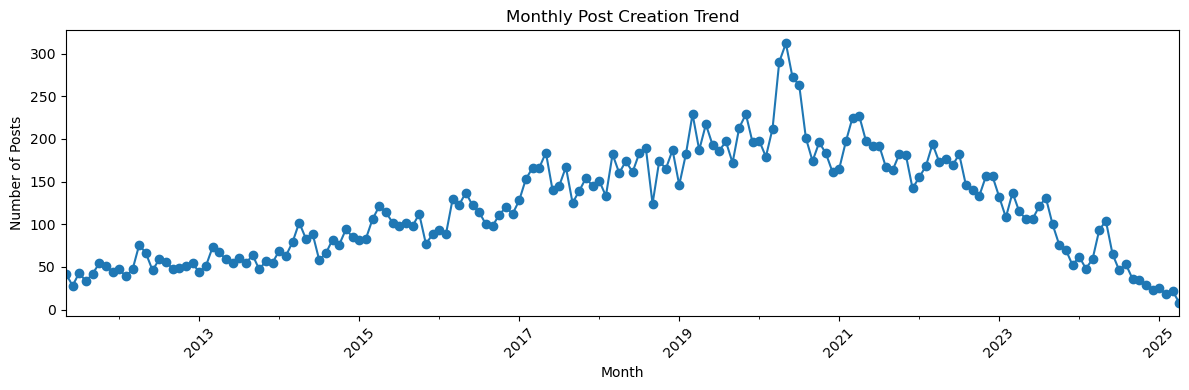

In [12]:
# Monthly trend of post creation
df['creation_month'] = pd.to_datetime(df['creation_date'], errors='coerce').dt.to_period('M')
monthly_post_counts = df['creation_month'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
monthly_post_counts.plot(kind='line', marker='o')
plt.title('Monthly Post Creation Trend')
plt.ylabel('Number of Posts')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Pre-processing

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ——— 1. Load the original dataset
df_orig = pd.read_csv('so_nlp_posts.csv', encoding='utf-8-sig')

# ——— 2. Create a new DataFrame for preprocessing
df_clean = df_orig.copy()

# ——— 3. Apply preprocessing (code from COMP_SCI_X_0001 Workshop Week2) 
def clean_text(text):
    """Lowercase, strip HTML, remove URLs/punctuation, tokenize and remove stopwords."""
    text = text.lower()                            # lower case
    text = re.sub(r'<[^>]+>', ' ', text)           # remove HTML tags
    text = re.sub(r'http\S+', ' ', text)           # remove URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)       # remove punctuation/special chars
    text = re.sub(r'[^a-z\s]', ' ', text)          # remove special characters, digits, and HTML entities
    tokens = word_tokenize(text)                   # tokenize  
    tokens = [t for t in tokens if t not in stop_words and t.isalpha() and len(t) > 1] # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]                  # lemmatization
    return ' '.join(tokens)

# ——— 4. Apply preprocessing 
df_clean['title_clean'] = df_clean['title'].astype(str).apply(clean_text)
df_clean['body_clean'] = df_clean['body'].astype(str).apply(clean_text)
df_clean['answer_clean'] = df_clean['accepted_answer_body'].astype(str).apply(clean_text)

# ——— 5. Display the first few rows of the new DataFrame
df_clean.head()

[nltk_data] Downloading package punkt to /Users/maomaoxun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maomaoxun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maomaoxun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


question_id                                              title  \
0     79577043  Unsupervised Topic Modeling for Short Event De...   
1     79574001  Is there a way to reuse a heavy service across...   
2     79572620  How can I link tasks using machine learning / ...   
3     79559702  NameError: name &#39;init_empty_weights&#39; i...   
4     79557354  Sentencepiece not generating models after prep...   

                                                body  \
0  <p>I have a dataset of approximately 750 lines...   
1  <p>I'm building an Airflow DAG where some of t...   
2  <p>I'm working on an AI model to predict depen...   
3  <p>I am trying to set up hugging face locally ...   
4  <p>So this is the log that I see on the termin...   

                                                tags    creation_date  \
0                machine-learning,nlp,topic-modeling  16/4/2025 11:17   
1                          nlp,airflow,microservices  14/4/2025 21:04   
2  python,machine-learning,nlp,artificial-intelli...  14/4/2025 07:51   
3           nlp,huggingface-transformers,huggingface   7/4/2025 11:02   
4                           python,nlp,sentencepiece   5/4/2025 18:21   

   view_count  accepted_answer_id  \
0        33.0                 NaN   
1        19.0                 NaN   
2        95.0                 NaN   
3       627.0          79577000.0   
4        54.0                 NaN   

                                accepted_answer_body  answerer_reputation  \
0                                                NaN                  NaN   
1                                                NaN                  NaN   
2                                                NaN                  NaN   
3  <p>Try using this version, it should resolve t...                 26.0   
4                                                NaN                  NaN   

                                         title_clean  \
0  unsupervised topic modeling short event descri...   
1        way reuse heavy service across task airflow   
2  link task using machine learning ai based hist...   
3  nameerror name init empty weight defined using...   
4  sentencepiece generating model preprocessing s...   

                                          body_clean  \
0  dataset approximately line containing quite sh...   
1  building airflow dag step ml nlp processing se...   
2  working ai model predict dependency link task ...   
3  trying set hugging face locally im running iss...   
4  log see terminal sentencepiece trainer cc log ...   

                                  answer_clean  
0                                          nan  
1                                          nan  
2                                          nan  
3  try using version resolve issue transformer  
4                                          nan

In [23]:
# Graphical representation of the dataset 

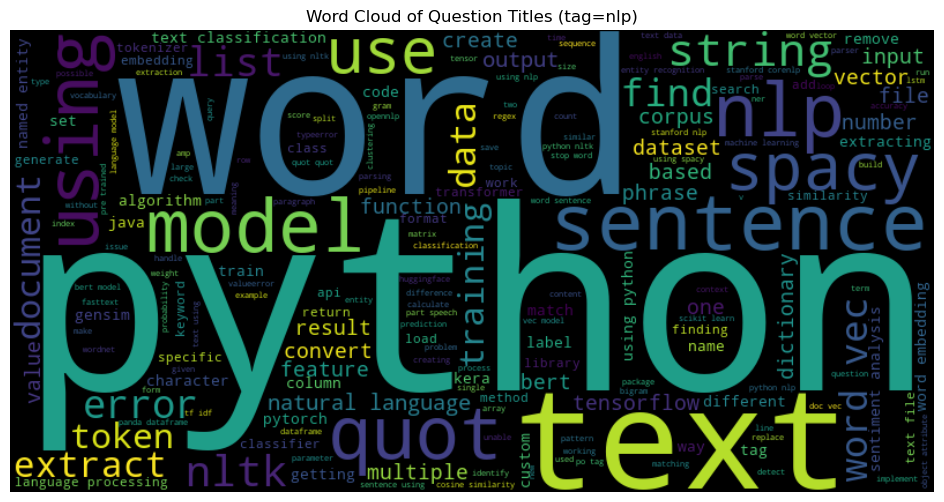

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ——— 1. Apply Word cloud (Müller, n.d.)
title_text = ' '.join(df_clean['title_clean'].tolist())
wordcloud = WordCloud(width=800, height=400).generate(title_text)

# ——— 2. Display the most frequent terms in title_clean column
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Question Titles (tag=nlp)")
plt.show()


In [22]:
# 4. Extract top 10 most frequent words (Müller, n.d.)
freq_dict = wordcloud.words_ 
top10 = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 most frequent terms in titles:")
for word, freq in top10:
    print(f"{word}: {freq:.2f}")

Top 10 most frequent terms in titles:
python: 1.00
word: 0.97
text: 0.91
sentence: 0.70
nlp: 0.63
using: 0.60
quot: 0.59
model: 0.59
spacy: 0.58
use: 0.54


In [ ]:
# Data Categorization 

In [23]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# ——— 1. Load pre‑processed dataset
df_cate = df_clean.copy()

# ——— 2. Filter out rows with no accepted answer, rename to df_cate
num_nan_answers = df_cate['accepted_answer_body'].isna().sum()
num_total = len(df_cate) + num_nan_answers  

df_cate = df_cate[~df_cate['accepted_answer_body'].isna()].copy()
print(f"Number of questions after filtering: {len(df_cate)}")


# ——— 3. Combine title, body, and accepted answer into one document per row
documents = (df_cate['title_clean'] + ' ' +
             df_cate['body_clean']  + ' ' +
             df_cate['answer_clean']).tolist()

# ——— 4. Tokenize each document
tokenized_docs = [word_tokenize(doc) for doc in documents]

# ——— 5. Create Gensim dictionary and corpus （code from COMP_SCI_X_0001 Workshop Week 8）
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]



Number of questions after filtering: 2473


[nltk_data] Downloading package punkt to /Users/maomaoxun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maomaoxun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# ——— 6. Train LDA model (Řehůřek, n.d.)
NUM_TOPICS = 20
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, passes=10, random_state=42)

# ——— 7.Compute coherence for each topic (Řehůřek, n.d.)
coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_per_topic = coherence_model.get_coherence_per_topic()

# ——— 8. Count documents per topic
topics_data = []
topic_counts = [0] * NUM_TOPICS

for doc_bow in corpus:
    topic_distribution = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    topic_counts[dominant_topic] += 1

# ——— 9. Collect topic data
for topic_id in range(NUM_TOPICS):
    top_words = lda_model.show_topic(topic_id, topn=20)
    keywords = [word for word, _ in top_words]
    topics_data.append({
        "Topic ID": topic_id,
        "Top Keywords": ", ".join(keywords),
        "Number of Questions": topic_counts[topic_id],
        "Coherence Score": coherence_per_topic[topic_id]
    })

df_topics = pd.DataFrame(topics_data)
df_topics_sorted = df_topics.sort_values(by="Coherence Score", ascending=False)
df_topics_sorted

Topic ID                                       Top Keywords  \
14        14  input, model, layer, embedding, output, tf, si...   
11        11  file, line, python, nltk, py, import, package,...   
2          2  would, one, model, data, example, sentence, al...   
16        16  language, natural, paragraph, question, englis...   
17        17  model, quot, id, self, train, label, data, tok...   
15        15  feature, test, data, train, import, document, ...   
7          7  new, string, system, sentence, get, println, t...   
4          4  java, org, apache, edu, opennlp, nlp, stanford...   
8          8  sentence, model, stanford, file, ner, nlp, par...   
0          0  doc, model, vector, token, topic, corpus, vec,...   
9          9  verb, noun, po, false, sentence, root, phrase,...   
6          6  synset, tag, nltk, po, wordnet, love, nn, tagg...   
10        10  tree, np, node, self, child, value, label, key...   
19        19  df, count, list, phrase, score, value, column,...   
13        13  nan, dfm, fn, self, utterance, quanteda, tenso...   
18        18  token, match, regex, pattern, name, entity, da...   
3          3  string, chunk, stem, sentence, print, len, ret...   
5          5  gt, lt, grammar, nltk, parse, production, new,...   
12        12  quot, name, entity, spacy, span, list, day, ex...   
1          1  file, review, document, corpus, sentence, data...   

    Number of Questions  Coherence Score  
14                  129         0.815096  
11                  160         0.646151  
2                   550         0.579276  
16                  139         0.571761  
17                  179         0.567563  
15                  118         0.562458  
7                    81         0.561322  
4                    21         0.499647  
8                   114         0.496823  
0                   176         0.492144  
9                    52         0.489718  
6                    90         0.476778  
10                   25         0.457062  
19                  201         0.445406  
13                    1         0.433706  
18                  103         0.381877  
3                    91         0.376708  
5                    57         0.371329  
12                  141         0.344161  
1                    45         0.328008

In [25]:
# ——— 10. Select High-Quality LDA Topics
df_filtered = df_topics_sorted[df_topics_sorted["Coherence Score"] > 0.5]
keywords_only = df_filtered["Top Keywords"]
for i, row in keywords_only.items():
    print(f"Topic {i}: {row}")

Topic 14: input, model, layer, embedding, output, tf, size, shape, kera, sequence, weight, length, decoder, none, lstm, encoder, batch, state, tensor, dense
Topic 11: file, line, python, nltk, py, import, package, lib, error, module, path, site, data, usr, corpus, user, open, self, txt, call
Topic 2: would, one, model, data, example, sentence, also, way, need, vector, problem, algorithm, want, could, two, different, training, good, used, probability
Topic 16: language, natural, paragraph, question, english, example, library, nlp, processing, api, would, sentence, google, speech, answer, search, part, etc, database, thing
Topic 17: model, quot, id, self, train, label, data, token, dataset, transformer, tokenizer, input, bert, loss, output, import, torch, sentence, batch, return
Topic 15: feature, test, data, train, import, document, classifier, nltk, set, fit, sklearn, print, corpus, stopwords, po, transform, vectorizer, neg, label, training
Topic 7: new, string, system, sentence, get, 

In [26]:
# Define topic labels
topic_labels = {
    14: "Deep Learning Model Architecture",
    11: "Python File & Package Handling",
    2:  "Model Building & Training Concepts",
    16: "NLP Applications & QA Systems",
    17: "Transformer/BERT Fine-tuning",
    15: "Text Classification & Feature Engineering",
    7:  "Syntactic Parsing in Java"
}

# Print table
topic_table = pd.DataFrame([
    {"Topic ID": tid, "Topic Label": label}
    for tid, label in topic_labels.items()
])
topic_table

Topic ID                                Topic Label
0        14           Deep Learning Model Architecture
1        11             Python File & Package Handling
2         2         Model Building & Training Concepts
3        16              NLP Applications & QA Systems
4        17               Transformer/BERT Fine-tuning
5        15  Text Classification & Feature Engineering
6         7                  Syntactic Parsing in Java

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ——— 1. Load dataset
df_rule =  pd.read_csv('so_nlp_posts_clean.csv', parse_dates=['creation_date'], encoding='utf-8-sig')

# ——— 2. Filter to include only posts with accepted answers
df_rule = df_rule[~df_rule['accepted_answer_body'].isna()].copy()

# ——— 3. Define category keywords
category_keywords = {
    "Preprocessing Tasks": [
        "tokenizer", "tokenization", "stopword", "stopwords", "stemming",
        "lemmatization", "cleaning", "normalize", "normalization",
        "punctuation", "lowercase", "remove html", "remove url", "regex"
    ],
    "Classification Tasks": [
        "classify", "classification", "classifier", "predict", "prediction",
        "sentiment", "intent", "topic", "label", "supervised",
        "naive bayes", "logistic regression", "svm", "random forest"
    ],
    "Sequence Modeling Tasks": [
        "lstm", "rnn", "gru", "seq2seq", "sequence-to-sequence", "sequence",
        "embedding", "padding", "recurrent", "bidirectional", "time steps"
    ],
    "Transformers / Language Modeling": [
        "transformer", "bert", "gpt", "t5", "roberta", "distilbert",
        "huggingface", "attention", "fine-tune", "pre-trained", "tokenizer",
        "encoder", "decoder", "model hub"
    ],
    "Annotation & Linguistic Analysis": [
        "parser", "parse", "dependency", "constituency", "pos", "pos tagging",
        "part-of-speech", "ner", "named entity", "coreference",
        "corenlp", "spacy", "stanford", "syntax", "semantic", "parse tree"
    ]
}

# ——— 4. Preprocess title text
df_rule['title_clean'] = df_rule['title_clean'].astype(str).str.lower()

# ——— 5. TF-IDF Vectorization on title_clean (code from COMP_SCI_X_0001 Workshop Week2)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_rule['title_clean'])

# ——— 6. Build TF-IDF vectors for category keyword lists
category_vectors = {}
for category, keywords in category_keywords.items():
    dummy_doc = ' '.join(keywords)
    vec = vectorizer.transform([dummy_doc])
    category_vectors[category] = vec

# ——— 7. Compute similarity and assign category （ChatGPT 2）
assigned_categories = []
similarity_scores = []
for i in range(tfidf_matrix.shape[0]):
    doc_vec = tfidf_matrix[i]
    best_category = None
    best_score = 0.15  # threshold
    for category, cat_vec in category_vectors.items():
        sim = cosine_similarity(doc_vec, cat_vec)[0][0]
        if sim > best_score:
            best_score = sim
            best_category = category
    assigned_categories.append(best_category)
    similarity_scores.append(best_score)

df_rule['task_category_sim'] = assigned_categories
df_rule['similarity_score'] = similarity_scores

# ——— 8. Filter to only posts that matched one of the categories
df_filtered = df_rule[~df_rule['task_category_sim'].isna()]
df_top100 = df_filtered.groupby('task_category_sim').head(20).copy()
df_top100 = df_top100.head(100)


/var/folders/9v/gsw0g5bx4d5_67ncd98w25yh0000gn/T/ipykernel_67813/3726900789.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_rule =  pd.read_csv('so_nlp_posts_clean.csv', parse_dates=['creation_date'], encoding='utf-8-sig')


In [28]:
# ——— 10. Data Visualisation
counts_df = df_top100['task_category_sim'].value_counts().reset_index()
counts_df.columns = ['NLP Task Category', 'Number of Posts']

avg_rep_df = df_top100.groupby('task_category_sim')['answerer_reputation'].mean().reset_index()
avg_rep_df.columns = ['NLP Task Category', 'Average Answerer Reputation']



summary_df = pd.merge(counts_df, avg_rep_df, on='NLP Task Category')

summary_df.sort_values(by='Average Answerer Reputation', ascending=False)

NLP Task Category  Number of Posts  \
4               Preprocessing Tasks               20   
1           Sequence Modeling Tasks               20   
2  Annotation & Linguistic Analysis               20   
3              Classification Tasks               20   
0  Transformers / Language Modeling               20   

   Average Answerer Reputation  
4                    113009.30  
1                     91220.10  
2                     71253.60  
3                     14794.05  
0                      9637.20

In [ ]:
# Measuring

In [30]:
# ——— 1. Randomly draw 100 samples
from sklearn.metrics import classification_report

samples = (
    df_rule.groupby('task_category_sim')
      .apply(lambda grp: grp.sample(20, random_state=42) if len(grp) >= 5 else grp)
      .reset_index(drop=True)
)
print(samples)


    question_id                                              title  \
0      15609324              Training n-gram NER with Stanford NLP   
1      75989822  What is Stanford CoreNLP&#39;s recipe for toke...   
2      51786224  Dependency Parsing using Stanford Dependency P...   
3      54640715                 Tokenizing Named Entities in Spacy   
4      61783003            Stanford CoreNLP Train custom NER model   
..          ...                                                ...   
95     77805776  How to calculate word and sentence embedding u...   
96     61350737  Is it possible to fine-tune BERT to do retweet...   
97     66561880  Weights of pre-trained BERT model not initialized   
98     56076874  Read GloVe pre-trained embeddings into R, as a...   
99     62525680  Save only best weights with huggingface transf...   

                                                 body  \
0   <p>Recently I have been trying to train n-gram...   
1   <p>Whether you're using Stanza or Corenlp

In [31]:
# ——— 2. Load dataset
df_body = samples

# ——— 3. Concatenate keywords into template text
category_templates = {cat: " ".join(kws) for cat, kws in category_keywords.items()}

# ——— 4. TF‑IDF vectorization: fitting template text, converting body_clean (code from COMP_SCI_X_0001 Workshop Week2)
vectorizer = TfidfVectorizer()
template_texts = list(category_templates.values())
template_names = list(category_templates.keys())

# ——— 5. Fitting template
templates_tfidf = vectorizer.fit_transform(template_texts)

# ——— 6. Convert post body to clean text
titles_tfidf = vectorizer.transform(df_body['body_clean'])

# ——— 7. Calculate cosine similarity and assign categories （ChatGPT 2）
sim_matrix = cosine_similarity(titles_tfidf, templates_tfidf)
threshold = 0.15

def assign_category(sim_row):
    best_idx = sim_row.argmax()
    return template_names[best_idx] if sim_row[best_idx] >= threshold else "Uncategorized"

df_body['true_category'] = [assign_category(row) for row in sim_matrix]

print("Assigned Category Counts:\n", df_body['true_category'].value_counts(), "\n")
print("Category Comparison:")
print(df_body[['title', 'task_category_sim', 'true_category']].head(10))

Assigned Category Counts:
 true_category
Transformers / Language Modeling    30
Annotation & Linguistic Analysis    20
Preprocessing Tasks                 17
Classification Tasks                15
Sequence Modeling Tasks             14
Uncategorized                        4
Name: count, dtype: int64 

Category Comparison:
                                               title  \
0              Training n-gram NER with Stanford NLP   
1  What is Stanford CoreNLP&#39;s recipe for toke...   
2  Dependency Parsing using Stanford Dependency P...   
3                 Tokenizing Named Entities in Spacy   
4            Stanford CoreNLP Train custom NER model   
5  Faster alternatives to Stanford CoreNLP for ob...   
6                  About training data for spaCy NER   
7              Escape parentheses in NLTK parse tree   
8  Confidence Score of Predicted NER entities usi...   
9          Is there any Part-Of-Speech tagger in C#?   

                  task_category_sim                     tru

In [180]:
# ——— 8. Prepare true values ​​and predicted values
y_true = df_body['true_category']
y_pred = df_body['task_category_sim']

labels = [
    "Preprocessing Tasks",
    "Classification Tasks",
    "Sequence Modeling Tasks",
    "Transformers / Language Modeling",
    "Annotation & Linguistic Analysis",
    "Uncategorized"
]

# ——— 9. Generate classification report
report = classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=labels,
    digits=4
)

print("Classification Report (Precision, Recall, F1-Score):\n")
print(report)

Classification Report (Precision, Recall, F1-Score):

                                  precision    recall  f1-score   support

             Preprocessing Tasks     0.7000    0.8235    0.7568        17
            Classification Tasks     0.5500    0.7333    0.6286        15
         Sequence Modeling Tasks     0.6500    0.9286    0.7647        14
Transformers / Language Modeling     1.0000    0.6667    0.8000        30
Annotation & Linguistic Analysis     0.8500    0.8500    0.8500        20
                   Uncategorized     0.0000    0.0000    0.0000         4

                        accuracy                         0.7500       100
                       macro avg     0.6250    0.6670    0.6333       100
                    weighted avg     0.7625    0.7500    0.7400       100



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x600 with 0 Axes>

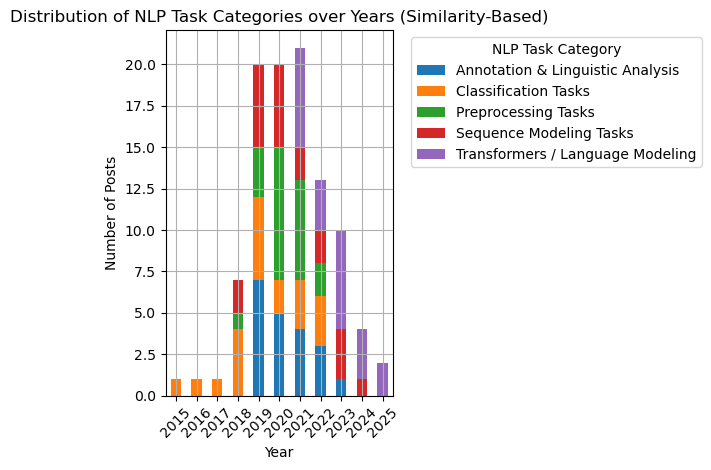

In [181]:
# Yearly distribution visualization
df_top100['year'] = df_top100['creation_date'].dt.year
task_year_distribution = df_top100.groupby(['year', 'task_category_sim']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
task_year_distribution.plot(kind='bar', stacked=True)
plt.title("Distribution of NLP Task Categories over Years (Similarity-Based)")
plt.ylabel("Number of Posts")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.legend(title="NLP Task Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()